In [1]:

import pandas as pd
import numpy as np
import os
import time
import json
import joblib
import importlib
from datetime import datetime
from scipy.sparse import save_npz

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import configurations
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import config
from config import PROCESSED_DATA_DIR, TRAIN_FILE, TEST_FILE, TEXT_COLUMN, PERSON_COUPLE_COLUMN, RANDOM_STATE

In [3]:
# file path for merged train and test data
# TRAIN_FILE, TEST_FILE = "train_merged.json", "test_merged.json"

In [4]:

def load_and_flatten_json(file_path):
    """
    Loads a nested JSON file and flattens it into a DataFrame.
    Concatenates dialogue turns into a single text string.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    processed_data = []
    for conversation in data:
        dialogue_text = " ".join(
            [f"[{turn['speaker']}] {turn['text']}" for turn in conversation['dialogue']]
        )
        processed_data.append({
            TEXT_COLUMN: dialogue_text,
            PERSON_COUPLE_COLUMN: conversation[PERSON_COUPLE_COLUMN]
        })
        
    return pd.DataFrame(processed_data)

In [5]:

# Load training and test data using the new function
print("Loading data")
train_path = os.path.join(PROCESSED_DATA_DIR, TRAIN_FILE)
test_path = os.path.join(PROCESSED_DATA_DIR, TEST_FILE)

df_train = load_and_flatten_json(train_path)
df_test = load_and_flatten_json(test_path)

print(f"Training data loaded: {df_train.shape[0]} rows")
print(f"Test data loaded: {df_test.shape[0]} rows")

Loading data
Training data loaded: 700 rows
Test data loaded: 150 rows


In [6]:

# Prepare data
X_train = df_train[TEXT_COLUMN]
y_train_labels = df_train[PERSON_COUPLE_COLUMN]

X_test = df_test[TEXT_COLUMN]
y_test_labels = df_test[PERSON_COUPLE_COLUMN]

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_test = label_encoder.transform(y_test_labels)

print("\nUnique classes:", label_encoder.classes_)
print("Number of classes:", len(label_encoder.classes_))


Unique classes: ['Controllore e Isolata' 'Dominante e Schiavo emotivo'
 'Geloso-Ossessivo e Sottomessa' 'Manipolatore e Dipendente emotiva'
 'Narcisista e Succube' 'Perfezionista Critico e Insicura Cronica'
 'Persona violenta e Succube' 'Psicopatico e Adulatrice'
 'Sadico-Crudele e Masochista' 'Vittimista e Croccerossina']
Number of classes: 10


In [7]:

# Vectorize text with TF-IDF
print("\nVectorizing text with TF-IDF")
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Training TF-IDF matrix shape:", X_train_tfidf.shape)


Vectorizing text with TF-IDF
Training TF-IDF matrix shape: (700, 10000)


In [ ]:
# Define and train Support Vector Machine model with GridSearchCV
print("\nTraining SVM model with GridSearchCV")
start_time = time.time()

# Parameters for the grid search, specific to SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'probability': [True] 
}

# Create the model
svm = SVC(random_state=RANDOM_STATE)
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


Training SVM model with GridSearchCV
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Training time: 12.21 seconds
Best parameters found: {'C': 1, 'gamma': 'scale', 'kernel': 'linear', 'probability': True}
Best cross-validation accuracy: 0.7128620862526441


In [9]:
# 1. Get best model and predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)
y_pred_probs = best_model.predict_proba(X_test_tfidf)
y_test_array = np.array(y_test)

print("\n" + "="*80)
print("                           MODEL EVALUATION RESULTS")
print("="*80)

# 2. Generate classification report as a dictionary
report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# 3. Get the indices of the top 2 and top 3 most likely classes
top2_preds_indices = np.argsort(y_pred_probs, axis=1)[:, -2:]
top3_preds_indices = np.argsort(y_pred_probs, axis=1)[:, -3:]

# 4. Build a list of dictionaries with all metrics per class
results_data = []
for class_index, class_name in enumerate(label_encoder.classes_):
    class_metrics = report_dict.get(class_name, {})
    indices_of_class = np.where(y_test_array == class_index)[0]
    
    class_top2_accuracy = 0.0
    class_top3_accuracy = 0.0
    if len(indices_of_class) > 0:
        class_correct_top2_count = np.sum([y_test_array[i] in top2_preds_indices[i] for i in indices_of_class])
        class_top2_accuracy = class_correct_top2_count / len(indices_of_class)
        
        class_correct_top3_count = np.sum([y_test_array[i] in top3_preds_indices[i] for i in indices_of_class])
        class_top3_accuracy = class_correct_top3_count / len(indices_of_class)

    results_data.append({
        'Precision': class_metrics.get('precision', 0),
        'Recall (Top-1 Acc)': class_metrics.get('recall', 0),
        'F1-Score': class_metrics.get('f1-score', 0),
        'Top-2 Accuracy': class_top2_accuracy,
        'Top-3 Accuracy': class_top3_accuracy,
        'Support': int(class_metrics.get('support', 0))
    })

# 5. Create the final, beautified pandas DataFrame
results_df = pd.DataFrame(results_data, index=label_encoder.classes_)
results_df.index.name = "Class"

print("\nPerformance Report per Class")

# Format the float columns to display as percentages
formatted_df = results_df.copy()
for col in ['Precision', 'Recall (Top-1 Acc)', 'F1-Score', 'Top-2 Accuracy', 'Top-3 Accuracy']:
    formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2%}")

print(formatted_df.to_string()) 

overall_accuracy = report_dict.get('accuracy', 0)
overall_top2_accuracy = np.sum([y_test_array[i] in top2_preds_indices[i] for i in range(len(y_test_array))]) / len(y_test_array)
overall_top3_accuracy = np.sum([y_test_array[i] in top3_preds_indices[i] for i in range(len(y_test_array))]) / len(y_test_array)

print("\n" + "-"*80)
print("Overall Performance Summary:")
print(f"  - Accuracy (Top-1): {overall_accuracy:.2%}")
print(f"  - Top-2 Accuracy:   {overall_top2_accuracy:.2%}")
print(f"  - Top-3 Accuracy:   {overall_top3_accuracy:.2%}")
print("="*80)


                           MODEL EVALUATION RESULTS

Performance Report per Class
                                         Precision Recall (Top-1 Acc) F1-Score Top-2 Accuracy Top-3 Accuracy  Support
Class                                                                                                                
Controllore e Isolata                       56.52%             86.67%   68.42%         86.67%         93.33%       15
Dominante e Schiavo emotivo                 81.82%             81.82%   81.82%         90.91%         90.91%       11
Geloso-Ossessivo e Sottomessa               85.71%             75.00%   80.00%         87.50%        100.00%        8
Manipolatore e Dipendente emotiva           66.67%             50.00%   57.14%         93.75%         93.75%       16
Narcisista e Succube                        58.82%             66.67%   62.50%         93.33%        100.00%       15
Perfezionista Critico e Insicura Cronica    84.62%             68.75%   75.86%         81.2

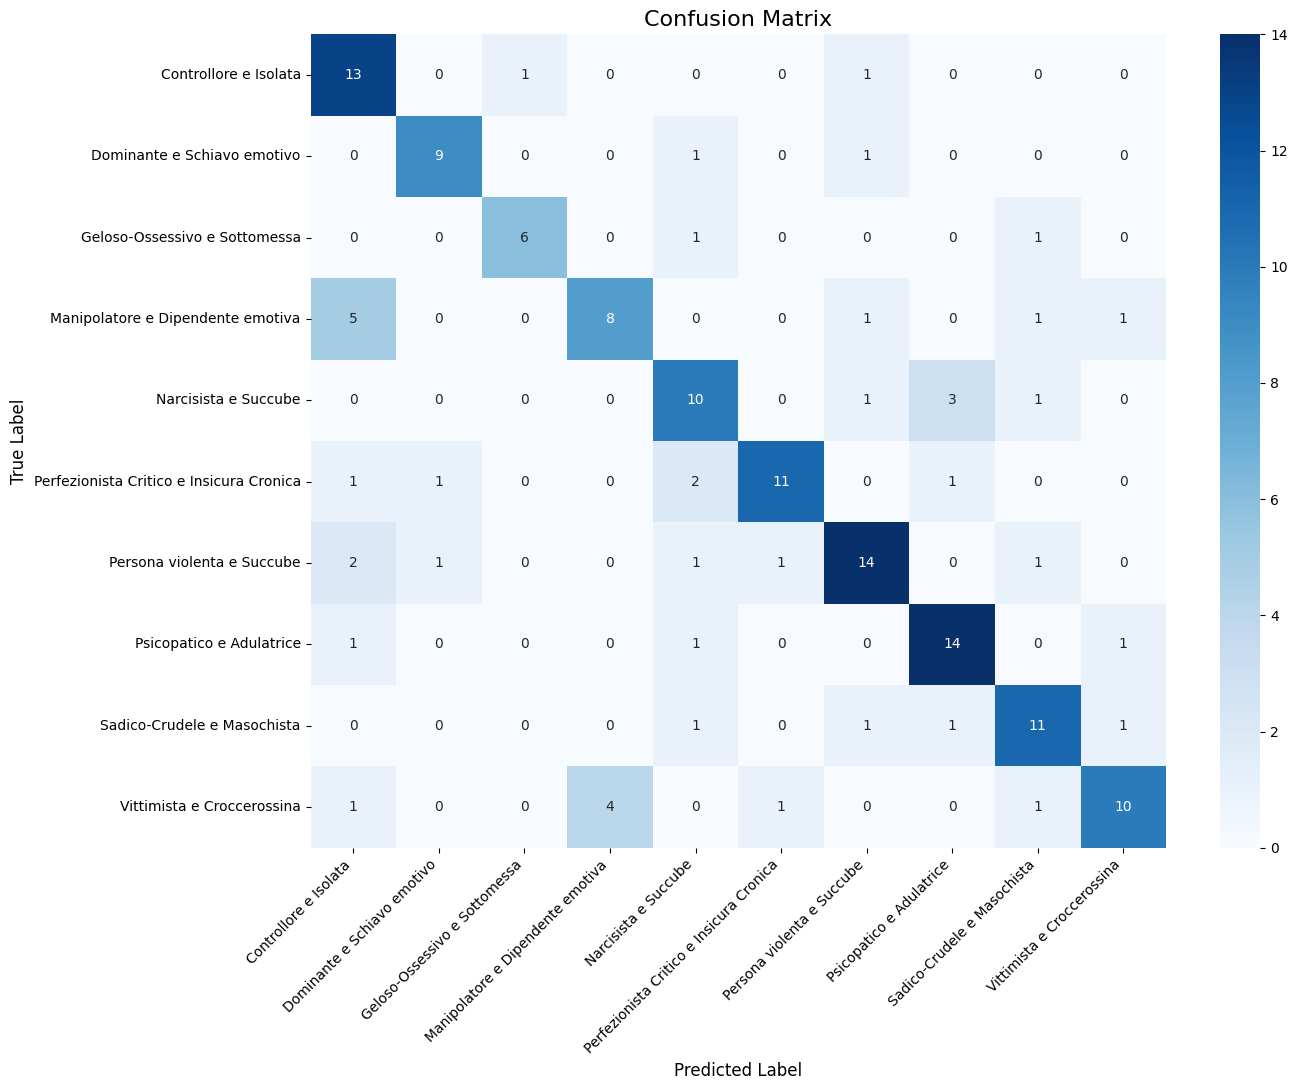

In [10]:

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,index = label_encoder.classes_, columns = label_encoder.classes_)


plt.figure(figsize=(14, 11))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout() 